<a href="https://colab.research.google.com/github/mdalarmansorker/AI-and-ML/blob/main/CNN_with_ResNet50_Model_with_car_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='cardataset.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('cardataset.zip')
f.keys()
!unzip cardataset.zip

Archive:  cardataset.zip
  inflating: Cars Dataset/test/Audi/1000.jpg  
  inflating: Cars Dataset/test/Audi/1003.jpg  
  inflating: Cars Dataset/test/Audi/1008.jpg  
  inflating: Cars Dataset/test/Audi/1020.jpg  
  inflating: Cars Dataset/test/Audi/1022.jpg  
  inflating: Cars Dataset/test/Audi/1025.jpg  
  inflating: Cars Dataset/test/Audi/1027.jpg  
  inflating: Cars Dataset/test/Audi/1038.jpg  
  inflating: Cars Dataset/test/Audi/104.jpg  
  inflating: Cars Dataset/test/Audi/1043.jpg  
  inflating: Cars Dataset/test/Audi/1051.jpg  
  inflating: Cars Dataset/test/Audi/1059.jpg  
  inflating: Cars Dataset/test/Audi/1060.jpg  
  inflating: Cars Dataset/test/Audi/1064.jpg  
  inflating: Cars Dataset/test/Audi/1066.jpg  
  inflating: Cars Dataset/test/Audi/1072.jpg  
  inflating: Cars Dataset/test/Audi/1073.jpg  
  inflating: Cars Dataset/test/Audi/1080.jpg  
  inflating: Cars Dataset/test/Audi/1084.jpg  
  inflating: Cars Dataset/test/Audi/1085.jpg  
  inflating: Cars Dataset/test/Audi/

In [3]:
train_dir = '/content/Cars Dataset/train'
validation_dir = '/content/Cars Dataset/test'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
no_classes = 7

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3352 files belonging to 7 classes.
Found 813 files belonging to 7 classes.


In [5]:
class_names = train_dataset.class_names
print(class_names)

['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


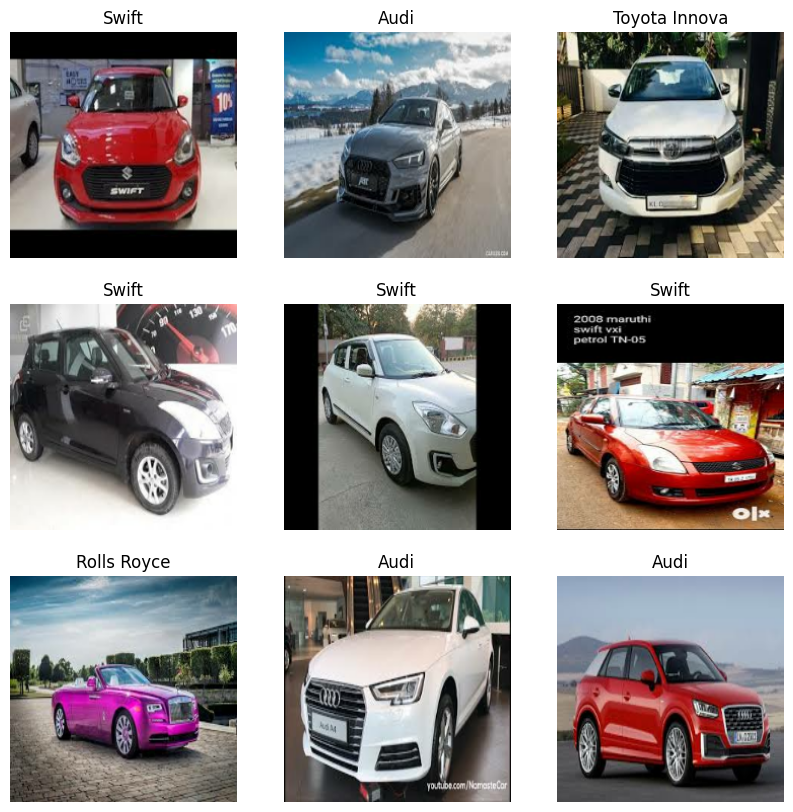

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(224, 224, 3))
ResNet50 = tf.keras.applications.ResNet50(
              include_top=False,
              weights=None #None for baseline, imagenet for transfer learning,
          )
#ResNet50.trainable = False #false if transfer learning, true if fine tuning
x = ResNet50(inputs) #x = ResNet50(inputs, training=False) if fine tuning
x = layers.Flatten()(x)
outputs = layers.Dense(no_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 7)                 702471    
                                                                 
Total params: 24,290,183
Trainable params: 24,237,063
Non-trainable params: 53,120
_________________________________________________________________


In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
)

Epoch 1/25
105/105 [==============================] - 103s 396ms/step - loss: 14.6194 - accuracy: 0.2073 - val_loss: 180.5064 - val_accuracy: 0.1513
Epoch 2/25
105/105 [==============================] - 36s 344ms/step - loss: 4.2658 - accuracy: 0.2751 - val_loss: 5.4071 - val_accuracy: 0.1009
Epoch 3/25
105/105 [==============================] - 38s 364ms/step - loss: 3.5580 - accuracy: 0.3637 - val_loss: 5.3351 - val_accuracy: 0.1722
Epoch 4/25
105/105 [==============================] - 37s 345ms/step - loss: 3.0090 - accuracy: 0.4150 - val_loss: 8.6784 - val_accuracy: 0.3100
Epoch 5/25
105/105 [==============================] - 36s 343ms/step - loss: 2.2158 - accuracy: 0.4714 - val_loss: 3.5273 - val_accuracy: 0.4465
Epoch 6/25
105/105 [==============================] - 36s 343ms/step - loss: 1.8494 - accuracy: 0.5304 - val_loss: 1.8258 - val_accuracy: 0.4920
Epoch 7/25
105/105 [==============================] - 36s 342ms/step - loss: 1.5183 - accuracy: 0.5946 - val_loss: 1.4640 - va

Saving 20221004033738_audi_r8_gt_front.jpg to 20221004033738_audi_r8_gt_front.jpg


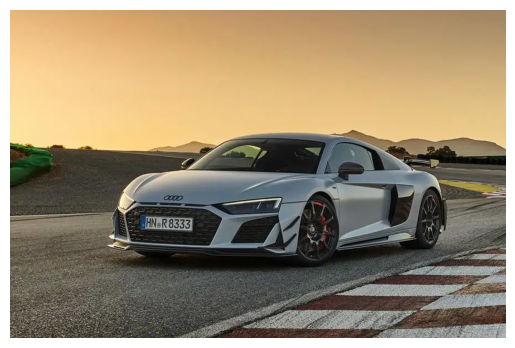

1/1 [==============================] - 0s 51ms/step
The predicted class is: Audi


In [12]:
#Testing by userinput image
import IPython.display as display
from PIL import Image
import io
from google.colab import files
from tensorflow import keras


# Prompt the user to upload an image file
uploaded_file = files.upload()

# Load the image using Pillow
img = Image.open(io.BytesIO(uploaded_file[next(iter(uploaded_file))]))

# Display the uploaded image
plt.imshow(img)
plt.axis('off')
plt.show()

# Save the image to the content folder
img.save('uploaded_image.jpg')

# Load the image from the content folder
img = keras.preprocessing.image.load_img(
    'uploaded_image.jpg', target_size=(224, 224)
)

# Convert the image to a numpy array
img_array = keras.preprocessing.image.img_to_array(img)

# Expand the dimensions of the image to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image
img_array = keras.applications.resnet50.preprocess_input(img_array)

# Make a prediction using the model
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print("The predicted class is:", predicted_class_name)
